In [2]:
import requests
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
import os
from unittest.mock import patch

import requests
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor
from transformers.dynamic_module_utils import get_imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# Mac solution => https://huggingface.co/microsoft/Florence-2-large-ft/discussions/4
def fixed_get_imports(filename: str | os.PathLike) -> list[str]:
    """Work around for https://huggingface.co/microsoft/phi-1_5/discussions/72."""
    if not str(filename).endswith("/modeling_florence2.py"):
        return get_imports(filename)
    imports = get_imports(filename)
    imports.remove("flash_attn")
    return imports


with patch("transformers.dynamic_module_utils.get_imports", fixed_get_imports):

    model = AutoModelForCausalLM.from_pretrained("yifeihu/TF-ID-base", trust_remote_code=True)
    processor = AutoProcessor.from_pretrained("yifeihu/TF-ID-base", trust_remote_code=True)


In [4]:
def process_image(url):
    prompt = "<OD>"

    image = Image.open(requests.get(url, stream=True).raw)

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        do_sample=False,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    result = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))
    return result, image

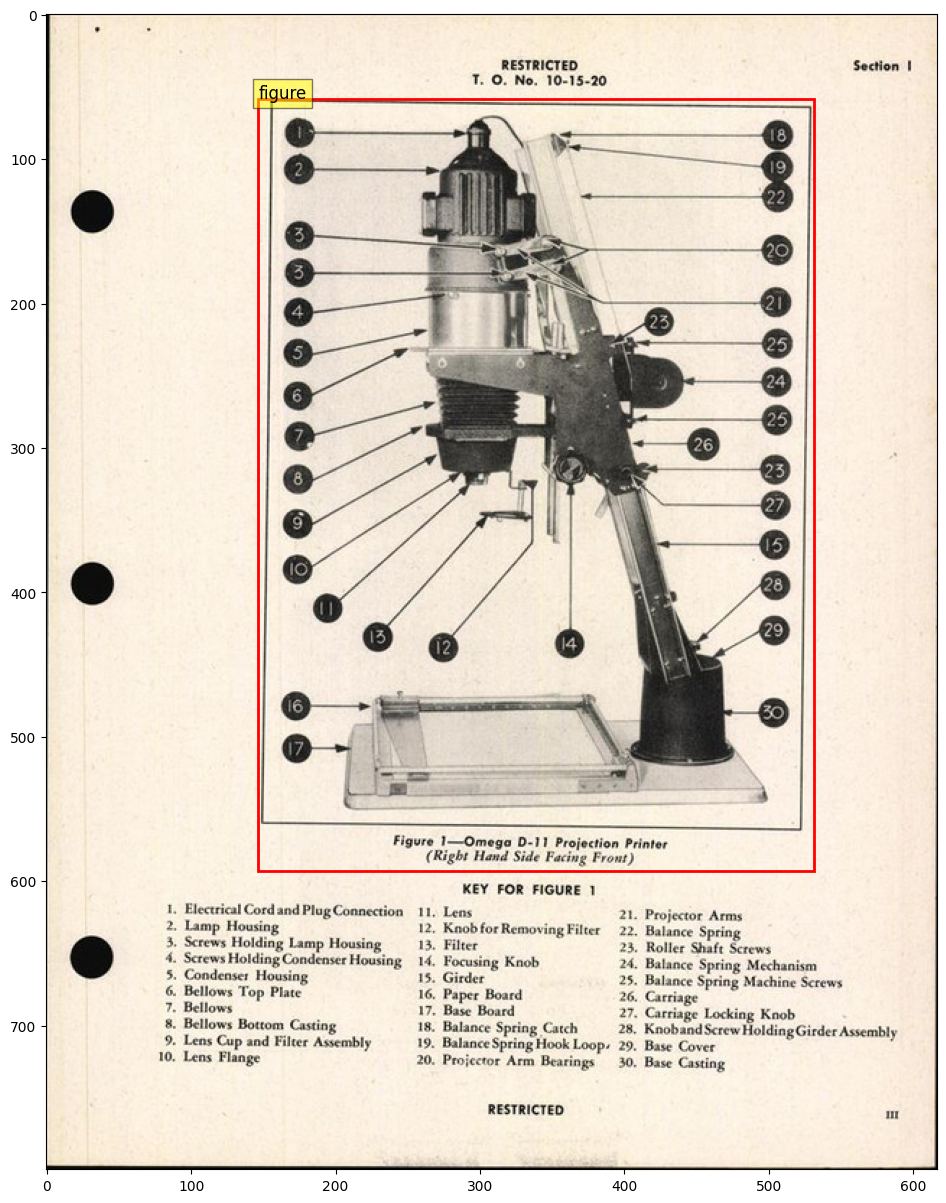

In [8]:
default_url = "https://huggingface.co/yifeihu/TF-ID-base/resolve/main/arxiv_2305_10853_5.png?download=true"

recipe_url = "https://i.pinimg.com/1200x/fb/3c/98/fb3c9850b116227fc89e42cd9a93e380.jpg"

toc_url = "https://cdn11.bigcommerce.com/s-xtgwxmwcif/images/stencil/640x800/products/3493/6456/1__53731.1605398326.jpg?c=1"

microscope_url = "https://cdn11.bigcommerce.com/s-xtgwxmwcif/images/stencil/640x800/products/3527/6520/5__77780.1605398486.jpg?c=1"

result, image = process_image(microscope_url)

fig, ax = plt.subplots(1, figsize=(15, 15))
ax.imshow(image)

# Add bounding boxes and labels to the plot
for bbox, label in zip(result['<OD>']['bboxes'], result['<OD>']['labels']):
    x, y, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x, y, label, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

# Display the plot
plt.show()